✅ Total images: 5722
class
notumor       1595
pituitary     1467
meningioma    1339
glioma        1321
Name: count, dtype: int64
📊 Train: 3890, Val: 687, Test: 1145
Found 3890 validated image filenames belonging to 4 classes.
Found 687 validated image filenames belonging to 4 classes.
Found 1145 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 339s 1s/step - accuracy: 0.6140 - loss: 0.9118 - val_accuracy: 0.2824 - val_loss: 6.0688 - learning_rate: 0.0010
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 51s 416ms/step - accuracy: 0.7482 - loss: 0.6412 - val_accuracy: 0.2780 - val_loss: 5.8941 - learning_rate: 0.0010
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 48s 394ms/step - accuracy: 0.7830 - loss: 0.5555 - val_accuracy: 0.2984 - val_loss: 12.0662 - learning_rate: 0.0010
Epoch 4/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 48s 395ms/step - accuracy: 0.8191 - loss: 0.4905 - val_accuracy: 0.2824 - val_loss: 6.0463 - learning_rate: 0.0010
Epoch 5/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 51s 420ms/step - accuracy: 0.8139 - loss: 0.4905 - val_accuracy: 0.4309 - val_loss: 4.3734 - learning_rate: 0.0010
Epoch 6/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 50s 407ms/step - accuracy: 0.8528 - loss: 0.4121 - val_accuracy: 0.5313 - val_loss: 1.3141 - learning_rate: 0.0010
Epoch 7/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 52s 422ms/step - accuracy: 0.86

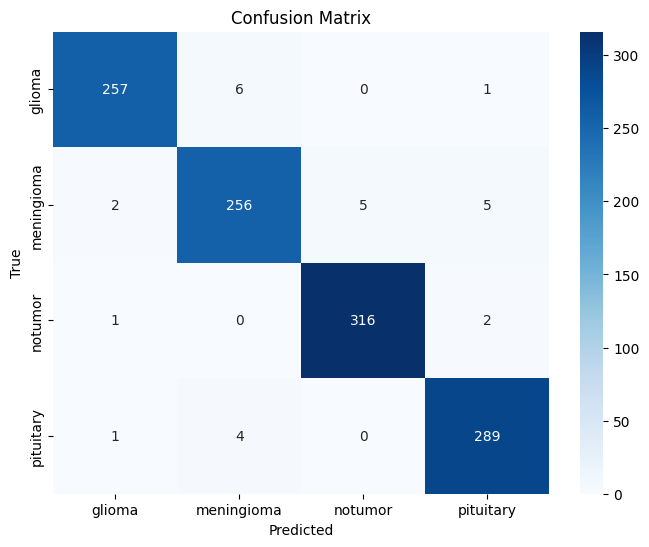

In [4]:
# ✅ Step 1: Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import seaborn as sns

# ✅ Step 2: Paths & Parameters
DATASET_PATH = "/kaggle/input/harvard-medical-dataset/Harvard_medical_dataset/Training"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50   # ⬅️ More epochs since training from scratch

# ✅ Step 3: Load image paths and labels
image_paths, labels = [], []
for class_dir in sorted(os.listdir(DATASET_PATH)):
    class_path = os.path.join(DATASET_PATH, class_dir)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_path, fname))
                labels.append(class_dir)

df = pd.DataFrame({'filename': image_paths, 'class': labels})
print(f"✅ Total images: {len(df)}")
print(df['class'].value_counts())

# ✅ Step 4: Split into train, val, test
train_df, test_df = train_test_split(df, stratify=df['class'], test_size=0.20, random_state=42)
train_df, val_df = train_test_split(train_df, stratify=train_df['class'], test_size=0.15, random_state=42)
print(f"📊 Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# ✅ Step 5: Create ImageDataGenerators
train_gen = ImageDataGenerator(rescale=1./255,   # ⬅️ from scratch, no preprocess_input
                                rotation_range=15,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                zoom_range=0.1,
                                horizontal_flip=True)

val_test_gen = ImageDataGenerator(rescale=1./255)

train_flow = train_gen.flow_from_dataframe(train_df, x_col='filename', y_col='class',
                                           target_size=IMG_SIZE, class_mode='categorical',
                                           batch_size=BATCH_SIZE)

val_flow = val_test_gen.flow_from_dataframe(val_df, x_col='filename', y_col='class',
                                            target_size=IMG_SIZE, class_mode='categorical',
                                            batch_size=BATCH_SIZE)

test_flow = val_test_gen.flow_from_dataframe(test_df, x_col='filename', y_col='class',
                                             target_size=IMG_SIZE, class_mode='categorical',
                                             batch_size=BATCH_SIZE, shuffle=False)

# ✅ Step 6: Build the Model (from scratch)
base_model = DenseNet121(weights=None, include_top=False, input_shape=(224, 224, 3))  

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
num_classes = len(train_flow.class_indices)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# ✅ Step 7: Compile
model.compile(optimizer=Adam(learning_rate=1e-3),  # ⬅️ slightly higher LR for scratch
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ✅ Step 8: Train
callbacks = [
    EarlyStopping(patience=8, restore_best_weights=True),
    ModelCheckpoint("best_densenet_scratch.keras", save_best_only=True),
    ReduceLROnPlateau(factor=0.2, patience=4, verbose=1)  # ⬅️ Reduce LR if stuck
]

history = model.fit(train_flow,
                    validation_data=val_flow,
                    epochs=EPOCHS,
                    callbacks=callbacks)

# ✅ Step 9: Evaluate
loss, acc = model.evaluate(test_flow)
print(f"\n✅ Test Accuracy: {acc * 100:.2f}%")

# ✅ Step 10: Predictions
y_true = test_flow.classes
y_pred = np.argmax(model.predict(test_flow), axis=1)
labels = list(test_flow.class_indices.keys())

print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

# ✅ Step 11: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()
